In [12]:
import os
import json
import math
import jieba
import dataclasses
import numpy as np
import logging
from dataclasses import field, dataclass
from gensim.models import KeyedVectors
from typing import List, Union, Dict, Any, Mapping, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

jieba.setLogLevel(logging.INFO)

In [13]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
@dataclass
class InputExample:

    guid: str
    text_a: str
    text_b: Optional[str] = None
    label: Optional[str] = None

    def to_json_string(self):
        return json.dumps(dataclasses.asdict(self), indent=2) + "\n"

@dataclass
class DataTrainingArguments:

    w2v_file: str = field(
        default='tencent-ailab-embedding-zh-d100-v0.2.0-s/tencent-ailab-embedding-zh-d100-v0.2.0-s.txt',
        metadata={'help': 'The pretrained word2vec model directory'}
    )
    data_dir: str = field(
        default='KUAKE-QQR',
        metadata={'help': 'The data directory'}
    )

    def __str__(self):
        self_as_dict = dataclasses.asdict(self)
        attrs_as_str = [f"{k}={v},\n" for k, v in sorted(self_as_dict.items())]
        return f"{self.__class__.__name__}(\n{''.join(attrs_as_str)})"
        
    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(dataclasses.asdict(self), indent=2) + "\n"


@dataclass
class ModelArguments:

    in_feat: int = field(
        default=100,
        metadata={'help': 'Size of input sample.'}
    )
    dropout_prob: float = field(
        default=0.1,
        metadata={'help': 'Dropout probability.'}
    )

    def __str__(self):
        self_as_dict = dataclasses.asdict(self)
        attrs_as_str = [f"{k}={v},\n" for k, v in sorted(self_as_dict.items())]
        return f"{self.__class__.__name__}(\n{''.join(attrs_as_str)})"
        
    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(dataclasses.asdict(self), indent=2) + "\n"


@dataclass
class TrainingArguments:

    output_dir: str = field(
        default='output_data/',
        metadata={'help': 'The output directory where the model predictions and checkpoints will be written.'}
    )
    train_batch_size: int = field(
        default=64,
        metadata={'help': 'batch size for training'}
    )
    eval_batch_size: int = field(
        default=32,
        metadata={'help': 'batch size for evaluation'}
    )
    num_train_epochs: int = field(
        default=27,
        metadata={"help": "The total number of training epochs"}
    )
    learning_rate: float = field(
        default=1e-3,
        metadata={'help': '"The initial learning rate for AdamW.'}
    )
    weight_decay: float = field(
        default=5e-4,
        metadata={"help": "Weight decay for AdamW"}
    )
    logging_steps: int = field(
        default=50,
        metadata={'help': 'logging states every X updates steps.'}
    )
    eval_steps: int = field(
        default=100,
        metadata={'help': 'Run an evaluation every X steps.'}
    )
    device: str = field(
        default='cuda',
        metadata={"help": 'The device used for training'}
    )

    def __str__(self):
        self_as_dict = dataclasses.asdict(self)
        attrs_as_str = [f"{k}={v},\n" for k, v in sorted(self_as_dict.items())]
        return f"{self.__class__.__name__}(\n{''.join(attrs_as_str)})"
        
    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(dataclasses.asdict(self), indent=2) + "\n"

In [15]:
# Tokenize string and Padding && Masking

class QQRDataset(Dataset):

    def __init__(
        self,
        examples: List[InputExample],
        label_list: List[Union[str, int]],
        vocab_mapping: Dict,
        max_length: int = 64,
    ):
        super().__init__()

        self.examples = examples

        self.vocab_mapping = vocab_mapping
        self.max_length = max_length

        self.label2id = {label: idx for idx, label in enumerate(label_list)}
        self.id2label = {idx: label for idx, label in enumerate(label_list)}

    def __len__(self):
        return len(self.examples)

    def _tokenize(self, text):
        # 文本分词
        tokens = list(jieba.cut(text))

        token_ids = []
        for token in tokens:
            if token in self.vocab_mapping:
                # 如果当前词存在于词表，将词转换为词的ID.
                token_id = self.vocab_mapping[token]
                token_ids.append(token_id)
            else:
                # OOV情况处理
                # 如果该词为多字的词，将其拆分多个字，分别将这些字转换为相应的ID；
                # 如果该词为单字，则从词表中随机采样一个词，其ID作为该词的ID
                if len(token) > 1:
                    for t in list(token):
                        if t in self.vocab_mapping:
                            token_ids.append(self.vocab_mapping[t])
                        else:
                            token_ids.append(np.random.choice(len(self.vocab_mapping), 1)[0])
                else:
                    token_ids.append(np.random.choice(len(self.vocab_mapping), 1)[0])

        # 对文本进行填充或者截断
        token_ids, attention_mask = self._pad_truncate(token_ids)
        
        return token_ids, attention_mask

    def _pad_truncate(self, token_ids: List[int]):
        # attention_mask作为标识文本填充情况
        attention_mask = None

        # 如果文本长度（以词为单位）大于设定的阈值，则截断末尾部分；
        # 如果文本长度小于设定的阈值，则填充0
        if len(token_ids) > self.max_length:
            token_ids = token_ids[:self.max_length], 
            attention_mask = [1] * self.max_length
        else:
            attention_mask = [1] * len(token_ids)

            diff = self.max_length - len(token_ids)
            token_ids.extend([0] * diff)
            attention_mask.extend([0] * diff)

        return token_ids, attention_mask        
        
    def __getitem__(self, index):
        
        example = self.examples[index]
        label = None
        if example.label is not None and len(example.label) > 0:
            label = self.label2id[example.label]

        # tokenize
        text_a_token_ids, text_a_attention_mask = self._tokenize(example.text_a)
        text_b_token_ids, text_b_attention_mask = self._tokenize(example.text_b)

        return {'text_a_input_ids': text_a_token_ids, 'text_b_input_ids': text_b_token_ids, 
                'text_a_attention_mask': text_a_attention_mask, 'text_b_attention_mask': text_b_attention_mask, 'label': label}


# Convert List of Dict to Tensor
class DataCollator:

    def __call__(self, features: List[Dict[str, Any]]):
        
        # 将一个batch内的样本输入转换为Tensor
        
        text_a_input_ids = []
        text_b_input_ids = []
        text_a_attention_mask = []
        text_b_attention_mask = []
        labels = []
        for item in features:
            text_a_input_ids.append(item['text_a_input_ids'])
            text_b_input_ids.append(item['text_b_input_ids'])
            text_a_attention_mask.append(item['text_a_attention_mask'])
            text_b_attention_mask.append(item['text_b_attention_mask'])
            if item['label'] is not None:
                labels.append(item['label'])
        
        text_a_input_ids = torch.tensor(text_a_input_ids, dtype=torch.long)
        text_b_input_ids = torch.tensor(text_b_input_ids, dtype=torch.long)
        text_a_attention_mask = torch.tensor(text_a_attention_mask, dtype=torch.bool)
        text_b_attention_mask = torch.tensor(text_b_attention_mask, dtype=torch.bool)
        if len(labels) > 0:
            labels = torch.tensor(labels, dtype=torch.long)
        else:
            labels = None

        return {'text_a_input_ids': text_a_input_ids, 'text_b_input_ids': text_b_input_ids, 
                'text_a_attention_mask': text_a_attention_mask, 'text_b_attention_mask': text_b_attention_mask, 'labels': labels}

In [16]:
class QQRProcessor:
    TASK = 'KUAKE-QQR'

    def __init__(self, data_dir):
        self.task_dir = os.path.join(data_dir)

    def get_train_examples(self):
        return self._create_examples(os.path.join(self.task_dir, f'{self.TASK}_train.json'))

    def get_dev_examples(self):
        return self._create_examples(os.path.join(self.task_dir, f'{self.TASK}_dev.json'))

    def get_test_examples(self):
        return self._create_examples(os.path.join(self.task_dir, f'{self.TASK}_test.json'))

    def get_labels(self):
        return ["0", "1", "2"]

    def _create_examples(self, data_path):

        # 读入文件
        with open(data_path, 'r', encoding='utf-8') as f:
            samples = json.load(f)

        examples = []
        for sample in samples:
            guid = sample['id']
            text_a = sample['query1']
            text_b = sample['query2']
            label = sample.get('label', None)

            examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))

        return examples

In [17]:
class Encoder(nn.Module):

    def __init__(self, in_feat: int = 100, dropout_prob: float = 0.1):
        super().__init__()

        self.lstm = nn.LSTM(input_size=in_feat, hidden_size=in_feat, bidirectional=True, batch_first=True)

    def forward(self, token_embeds, attention_mask):
        batch_size = attention_mask.size(0)
        output, (h, c) = self.lstm(token_embeds)
        output, lens_output = pad_packed_sequence(output, batch_first=True)   # [B, L, H]
        
        return output, lens_output


class Decoder(nn.Module):

    def __init__(self, in_feat: int = 100, dropout_prob: float = 0.1):
        super().__init__()

        self.lstm = nn.LSTM(input_size=in_feat, hidden_size=in_feat, bidirectional=True, batch_first=True)

    def forward(self, token_embeds, attention_mask):
        batch_size = attention_mask.size(0)
        output, (h, c) = self.lstm(token_embeds)
        output, lens_output = pad_packed_sequence(output, batch_first=True)   # [B, L, H]
        output = torch.stack([torch.mean(output[i][:lens_output[i]], dim=0) for i in range(batch_size)], dim=0)
        
        return output


class Classifier(nn.Module):

    def __init__(self, in_feat, num_labels: int, dropout_prob: float = 0.1):
        super().__init__()

        self.dense1 = nn.Linear(in_feat, in_feat // 2)
        self.dense2 = nn.Linear(in_feat // 2, num_labels)
        self.act = nn.Tanh()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):

        x = self.act(self.dense1(self.dropout(x)))
        x = self.dense2(self.dropout(x))

        return x


class CrossAttention(nn.Module):

    def __init__(self, in_feat, dropout):
        super().__init__()

        self.dense = nn.Linear(4*in_feat, in_feat//2)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(dropout)


    def forward(self, a, b, mask_a, mask_b):
        in_feat = a.size(-1)

        # a: [B, L1, H], b: [B, L2, H]
        # 计算query A和query B之间的attention score，即 Key * Value
        cross_attn = torch.matmul(a, b.transpose(1, 2))   # [B, L1, L2]

        # 将填充位置的score设为-1e9，即不考虑填充位置的信息
        row_attn = cross_attn.masked_fill((mask_b == False).unsqueeze(1), -1e9)
        row_attn = row_attn.softmax(dim=2)    # [B, L1, L2]

        col_attn = cross_attn.permute(0, 2, 1).contiguous()   # [B, L2, L1]
        col_attn = col_attn.masked_fill((mask_a == False).unsqueeze(1), -1e9)
        col_attn = col_attn.softmax(dim=2)

        # attention score * value
        attn_a = torch.matmul(row_attn, b)      # [B, L1, H]
        attn_b = torch.matmul(col_attn, a)      # [B, L2, H]
        
        diff_a = a - attn_a
        diff_b = b - attn_b
        prod_a = a * attn_a
        prod_b = b * attn_b

        # 将原本的hidden state和attention得到的hidden state拼接，并经过线性变换降维
        a = torch.cat([a, attn_a, diff_a, prod_a], dim=-1)    # [B, L1, 2*H]
        b = torch.cat([b, attn_b, diff_b, diff_b], dim=-1)    # [B, L2, 2*H]
        
        

        a = self.act(self.dense(self.dropout(a)))                # [B, L1, H/2]
        b = self.act(self.dense(self.dropout(b)))                # [B, L2, H/2]

        return a, b


class SemAttn(nn.Module):

    def __init__(
        self,
        in_feat: int = 100,
        num_labels: int = 3,
        dropout_prob: float = 0.1,
        w2v_state_dict: torch.Tensor = None,
        vocab_size: int = None,
        word_embedding_dim: int = None
    ):
        super().__init__()

        self.num_labels = num_labels
        self._init_word_embedding(w2v_state_dict, vocab_size, word_embedding_dim)
        
        self.encoder = Encoder(in_feat=in_feat, dropout_prob=dropout_prob)
        self.decoder = Decoder(in_feat=in_feat, dropout_prob=dropout_prob)
        self.cross_attn = CrossAttention(in_feat=in_feat*2, dropout=dropout_prob)
        self.classifier = Classifier(in_feat=4*in_feat, num_labels=num_labels, dropout_prob=dropout_prob)

    def _init_word_embedding(self, state_dict=None, vocab_size=None, word_embedding_dim=None):
        if state_dict is None:
            self.word_embedding = nn.Embedding(vocab_size, word_embedding_dim, padding_idx=0)
        else:
            # 默认载入预训练好的词向量（且固定词向量），并将其第一个词作为填充词（以及其对应向量设为零向量）
            state_dict = torch.tensor(state_dict.vectors, dtype=torch.float32)
            state_dict[0] = torch.zeros(state_dict.size(-1))
            self.word_embedding = nn.Embedding.from_pretrained(state_dict, freeze=True, padding_idx=0)
            
    def forward(
        self, 
        text_a_input_ids: torch.Tensor,
        text_b_input_ids: torch.Tensor,
        text_a_attention_mask: torch.Tensor,
        text_b_attention_mask: torch.Tensor, 
        labels=None
    ):

        text_a_vecs = self.word_embedding(text_a_input_ids)
        text_b_vecs = self.word_embedding(text_b_input_ids)

        text_a_vecs = pack_padded_sequence(text_a_vecs, text_a_attention_mask.cpu().long().sum(dim=-1), enforce_sorted=False, batch_first=True)
        text_b_vecs = pack_padded_sequence(text_b_vecs, text_b_attention_mask.cpu().long().sum(dim=-1), enforce_sorted=False, batch_first=True)

        text_a_attention_mask = pack_padded_sequence(text_a_attention_mask, text_a_attention_mask.cpu().long().sum(dim=-1), enforce_sorted=False, batch_first=True)
        text_b_attention_mask = pack_padded_sequence(text_b_attention_mask, text_b_attention_mask.cpu().long().sum(dim=-1), enforce_sorted=False, batch_first=True)
        text_a_attention_mask, _ = pad_packed_sequence(text_a_attention_mask, batch_first=True)
        text_b_attention_mask, _ = pad_packed_sequence(text_b_attention_mask, batch_first=True)

        # 两个query先独自经过encoder
        text_a_vecs, text_a_lens = self.encoder(text_a_vecs, text_a_attention_mask)
        text_b_vecs, text_b_lens = self.encoder(text_b_vecs, text_b_attention_mask)

        # 两个query通过Attention进行交互
        text_a_vecs, text_b_vecs = self.cross_attn(text_a_vecs, text_b_vecs, text_a_attention_mask, text_b_attention_mask)
        text_a_vecs = pack_padded_sequence(text_a_vecs, text_a_lens, enforce_sorted=False, batch_first=True)
        text_b_vecs = pack_padded_sequence(text_b_vecs, text_b_lens, enforce_sorted=False, batch_first=True)
        
        # 融合当前query的hidden states和attention后的hidden states的信息
        text_a_vec = self.decoder(text_a_vecs, text_a_attention_mask)
        text_b_vec = self.decoder(text_b_vecs, text_b_attention_mask)
        
        # 拼接两个query的表示，输入到分类器
        pooler_output = torch.cat([text_a_vec, text_b_vec], dim=-1)
        logits = self.classifier(pooler_output)
    
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else logits

In [18]:
def create_optimizer_and_lr_scheduler(
    args: TrainingArguments,
    model: nn.Module
):
    # 构建优化器
    optimizer = AdamW(
        model.parameters(), 
        lr=args.learning_rate,
        weight_decay=args.weight_decay,
    )
    # 构建学习率调度器
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=2, eta_min=1e-5)

    return optimizer, lr_scheduler


def _prepare_input(data: Union[torch.Tensor, Any], device: str = 'cuda'):
    # 将准备输入模型中的数据转到GPU上
    if isinstance(data, Mapping):
        return type(data)({k: _prepare_input(v, device) for k, v in data.items()})
    elif isinstance(data, (tuple, list)):
        return type(data)(_prepare_input(v, device) for v in data)
    elif isinstance(data, torch.Tensor):
        kwargs = dict(device=device)
        return data.to(**kwargs)
    return data


def simple_accuracy(preds, labels):

    return (preds == labels).mean()
    

def evaluate(
    args: TrainingArguments,
    model: nn.Module,
    eval_dataloader
):
    model.eval()
    loss_list = []
    preds_list = []
    labels_list = []

    for item in eval_dataloader:
        inputs = _prepare_input(item, device=args.device)

        with torch.no_grad():
            outputs = model(**inputs)
            loss = outputs[0]
            loss_list.append(loss.detach().cpu().item())

            preds = torch.argmax(outputs[1].cpu(), dim=-1).numpy()
            preds_list.append(preds)

            labels_list.append(inputs['labels'].cpu().numpy())
    
    preds = np.concatenate(preds_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    loss = np.mean(loss_list)
    accuracy = simple_accuracy(preds, labels)

    model.train()

    return loss, accuracy


def train(
    args: TrainingArguments,
    model: nn.Module,
    train_dataset,
    dev_dataset,
    data_collator,
):

    # initialize dataloader
    train_dataloader = DataLoader(
        dataset=train_dataset, 
        batch_size=args.train_batch_size,
        shuffle=True,
        collate_fn=data_collator
    )
    dev_dataloader = DataLoader(
        dataset=dev_dataset,
        batch_size=args.eval_batch_size,
        shuffle=False,
        collate_fn=data_collator
    )

    num_examples = len(train_dataloader.dataset)
    num_update_steps_per_epoch = len(train_dataloader)
    num_update_steps_per_epoch = max(num_update_steps_per_epoch, 1)
    
    max_steps = math.ceil(args.num_train_epochs * num_update_steps_per_epoch)
    num_train_epochs = math.ceil(args.num_train_epochs)
    num_train_samples = len(train_dataset) * args.num_train_epochs

    optimizer, lr_scheduler = create_optimizer_and_lr_scheduler(args, model)

    print("***** Running training *****")
    print(f"  Num examples = {num_examples}")
    print(f"  Num Epochs = {args.num_train_epochs}")
    print(f"  Instantaneous batch size per device = {args.train_batch_size}")
    print(f"  Total train batch size (w. parallel, distributed & accumulation) = {args.train_batch_size}")
    print(f"  Total optimization steps = {max_steps}")

    model.zero_grad()
    model.train()
    global_steps = 0

    best_metric = 0.0
    best_steps = -1
    log_history = {
        'train_loss': [],
        'eval_loss': [],
        'eval_accuracy': []
    }
    for epoch in range(num_train_epochs):
        for step, item in enumerate(train_dataloader):
            inputs = _prepare_input(item, device=args.device)
            outputs = model(**inputs)
            loss = outputs[0]

            loss.backward()
            optimizer.step()
            lr_scheduler.step(epoch + step / num_update_steps_per_epoch)
            model.zero_grad()
            global_steps += 1

            if global_steps % args.logging_steps == 0:
                print(f'Training: Epoch {epoch + 1}/{num_train_epochs} - Step {(step + 1)} - Loss {loss}')
                log_history['train_loss'].append(loss.detach().cpu().item())

            if global_steps % args.eval_steps == 0:
                
                loss, acc = evaluate(args, model, dev_dataloader)
                print(f'Evaluation: Epoch {epoch + 1}/{num_train_epochs} - Step {(global_steps + 1)} - Loss {loss} - Accuracy {acc}')
                log_history['eval_loss'].append(loss)
                log_history['eval_accuracy'].append(acc)
                if acc > best_metric:
                    best_metric = acc
                    best_steps = global_steps
                    
                    saved_path = os.path.join(args.output_dir, f'checkpoint-{best_steps}.pt')
                    torch.save(model.state_dict(), saved_path)

    return best_steps, best_metric, log_history

In [19]:
def predict(
    args: TrainingArguments,
    model: nn.Module,
    test_dataset,
    data_collator
):
    
    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=args.eval_batch_size,
        shuffle=False,
        collate_fn=data_collator
    )
    print("***** Running prediction *****")
    model.eval()
    preds_list = []

    for item in test_dataloader:
        inputs = _prepare_input(item, device=args.device)

        with torch.no_grad():
            outputs = model(**inputs)

            preds = torch.argmax(outputs.cpu(), dim=-1).numpy()
            preds_list.append(preds)

    print(f'Prediction Finished!')
    preds = np.concatenate(preds_list, axis=0).tolist()

    model.train()

    return preds


def generate_commit(output_dir, task_name, test_dataset, preds: List[int]):

    test_examples = test_dataset.examples
    pred_test_examples = []
    for idx in range(len(test_examples)):
        example = test_examples[idx]
        label  = test_dataset.id2label[preds[idx]]
        pred_example = {'id': example.guid, 'query1': example.text_a, 'query2': example.text_b, 'label': label}
        pred_test_examples.append(pred_example)
    
    with open(os.path.join(output_dir, f'{task_name}_test.json'), 'w', encoding='utf-8') as f:
        json.dump(pred_test_examples, f, indent=2, ensure_ascii=False)

In [20]:
import time

data_args = DataTrainingArguments(data_dir='../data/KUAKE-QQR',  w2v_file='../data/tencent-ailab-embedding-zh-d100-v0.2.0-s/tencent-ailab-embedding-zh-d100-v0.2.0-s.txt')
training_args = TrainingArguments()
model_args = ModelArguments()
print(data_args)
print(training_args)
print(model_args)

#载入词向量
w2v_model = KeyedVectors.load_word2vec_format(data_args.w2v_file, binary=False)

DataTrainingArguments(
data_dir=../data/KUAKE-QQR,
w2v_file=../data/tencent-ailab-embedding-zh-d100-v0.2.0-s/tencent-ailab-embedding-zh-d100-v0.2.0-s.txt,
)
TrainingArguments(
device=cuda,
eval_batch_size=32,
eval_steps=100,
learning_rate=0.001,
logging_steps=50,
num_train_epochs=27,
output_dir=output_data/,
train_batch_size=64,
weight_decay=0.0005,
)
ModelArguments(
dropout_prob=0.1,
in_feat=100,
)


In [25]:
processor = QQRProcessor(data_dir=data_args.data_dir)

train_dataset = QQRDataset(
    processor.get_train_examples(), 
    processor.get_labels(),
    vocab_mapping=w2v_model.key_to_index,
    max_length=32
)
eval_dataset = QQRDataset(
    processor.get_dev_examples(),
    processor.get_labels(),
    vocab_mapping=w2v_model.key_to_index,
    max_length=32
)
test_dataset = QQRDataset(
    processor.get_test_examples(),
    processor.get_labels(),
    vocab_mapping=w2v_model.key_to_index,
    max_length=32
)

data_collator = DataCollator()

In [26]:
# 创建输出结果（模型、参数、预测结果）的文件夹
model_name = f'semattn-{str(int(time.time()))}'
training_args.output_dir = os.path.join(training_args.output_dir, model_name)
if not os.path.exists(training_args.output_dir):
    os.makedirs(training_args.output_dir, exist_ok=True)

In [27]:
# 初始化模型
print('Initialize model')
training_args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SemAttn(
    in_feat=model_args.in_feat, 
    num_labels=len(processor.get_labels()), 
    dropout_prob=model_args.dropout_prob,
    w2v_state_dict=w2v_model,
)
model.to(training_args.device)

Initialize model


SemAttn(
  (word_embedding): Embedding(2000000, 100, padding_idx=0)
  (encoder): Encoder(
    (lstm): LSTM(100, 100, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(100, 100, batch_first=True, bidirectional=True)
  )
  (cross_attn): CrossAttention(
    (dense): Linear(in_features=800, out_features=100, bias=True)
    (act): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (classifier): Classifier(
    (dense1): Linear(in_features=400, out_features=200, bias=True)
    (dense2): Linear(in_features=200, out_features=3, bias=True)
    (act): Tanh()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [ ]:
# 训练模型
print('Training...')
best_steps, best_metric,log_history = train(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    dev_dataset=eval_dataset,
    data_collator=data_collator
)

print(f'Training Finished! Best step - {best_steps} - Best accuracy {best_metric}')

best_model_path = os.path.join(training_args.output_dir, f'checkpoint-{best_steps}.pt')
log_history_path = os.path.join(training_args.output_dir, 'log_history.json')
with open(log_history_path, 'w', encoding='utf-8') as f:
    json.dump(log_history, f, indent=2, ensure_ascii=False)

best_model_path = os.path.join(training_args.output_dir, f'checkpoint-{best_steps}.pt')


Training...
***** Running training *****
  Num examples = 15000
  Num Epochs = 27
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Total optimization steps = 6345
Training: Epoch 1/27 - Step 50 - Loss 0.912455141544342
Training: Epoch 1/27 - Step 100 - Loss 0.6376833319664001
Evaluation: Epoch 1/27 - Step 101 - Loss 0.7874438917636871 - Accuracy 0.62875
Training: Epoch 1/27 - Step 150 - Loss 0.6263372302055359
Training: Epoch 1/27 - Step 200 - Loss 0.42311912775039673
Evaluation: Epoch 1/27 - Step 201 - Loss 0.7450573121011257 - Accuracy 0.689375
Training: Epoch 2/27 - Step 15 - Loss 0.4817622900009155
Training: Epoch 2/27 - Step 65 - Loss 0.5640130639076233
Evaluation: Epoch 2/27 - Step 301 - Loss 0.7350121760368347 - Accuracy 0.68875
Training: Epoch 2/27 - Step 115 - Loss 0.4801297187805176
Training: Epoch 2/27 - Step 165 - Loss 0.6462610960006714
Evaluation: Epoch 2/27 - Step 401 - Loss 0.721651519536972 - Accuracy 

NameError: name 'SemLSTM' is not defined

In [30]:
model = SemAttn(
    in_feat=model_args.in_feat, 
    num_labels=len(processor.get_labels()), 
    dropout_prob=model_args.dropout_prob,
    w2v_state_dict=w2v_model,
)
model.load_state_dict(torch.load(best_model_path, map_location='cpu'))
model.to(training_args.device)

# 保存最佳模型及超参数
torch.save(model.state_dict(), os.path.join(training_args.output_dir, 'pytorch_model.bin'))
torch.save(training_args, os.path.join(training_args.output_dir, 'training_args.bin'))

# 预测及生成预测结果（供提交到平台）
preds = predict(training_args, model, test_dataset, data_collator)
generate_commit(training_args.output_dir, processor.TASK, test_dataset, preds)

C:\Users\runze\AppData\Local\Temp\ipykernel_50396\2135723145.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_locati

***** Running prediction *****
Prediction Finished!


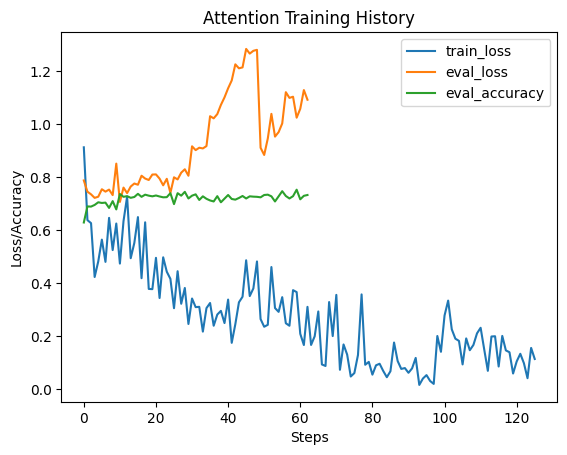

In [31]:
history = json.load(open(log_history_path, 'r', encoding='utf-8'))

import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['eval_loss'], label='eval_loss')
plt.plot(history['eval_accuracy'], label='eval_accuracy')
plt.legend()
plt.title('Attention Training History')
plt.xlabel('Steps')
plt.ylabel('Loss/Accuracy')
plt.show()